# JHU covid-19 daily data processing 

Test and update functions for JHU data analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import glob
import os
 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 

from datetime import timedelta 
import datetime
import pytz
from tzwhere import tzwhere  
import geopandas as gpd
import shapely.affinity as shp

from matplotlib.dates import date2num       #-->Update

import matplotlib
from matplotlib import cm


import os
import sys
base_path = os.path.dirname( os.getcwd()  )   
sys.path.append(base_path ) 
import JHU_dataprocessing_functions as dp
import JHU_plotting_functions as jp 

# general parameters 

In [2]:
full_w = (12,7)
half_w = (6,4)

# Load daily reports 

In [3]:
daily_path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'
daily_path_us = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports_us'

df_daily = dp.load_daily_reports(daily_path, daily_path_us)
df_state = dp.process_daily_data( df_daily ) 

# transform state geometry 

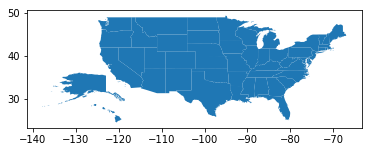

In [4]:
data_path = os.path.join(  base_path,  'geo_data\states.shp' )  
US = gpd.read_file(data_path) 
    
def move_scale_state( df, state_name, scaling_ratio, xy_movement): 
    # get original polygons
    bool_state = df['STATE_NAME'] == state_name
    state_object = df.loc[bool_state,'geometry']
    state_geom = df.loc[bool_state,'geometry'].iloc[0] 

    state_moved = shp.translate(state_geom, xy_movement[0], xy_movement[1])  
    centroid = state_moved.centroid
    state_scaled = shp.scale( state_moved, xfact=scaling_ratio, yfact=scaling_ratio, origin=centroid) 
    state_object.iloc[0] = state_scaled
    df.loc[bool_state,'geometry'] = state_object
    
    return df 
 
US = move_scale_state( US, 'Alaska', 0.4, [25,-31]) 
US = move_scale_state( US, 'Hawaii', 1.3, [35,6])

US.plot() 

# find average increase

In [5]:
US['average_increase']=0
 
dates = df_state['Date'].sort_values().unique()

for state in US['STATE_NAME'].unique(): 
    
    in_state = df_state['State'] == state 
    bool_date = df_state['Date'] == dates[-1]
    bool_prior = df_state['Date'] == dates[-7]  
    
    if (np.sum(bool_date&in_state) > 0) & (np.sum(bool_prior&in_state) > 0):
        cases_date = df_state.loc[bool_date&in_state,'Confirmed'].values
        cases_prior = df_state.loc[bool_prior&in_state,'Confirmed'].values 
        latest_cases = (cases_date-cases_prior)/7
    else:
        latest_cases = 2
    
    bool_US_state = US['STATE_NAME'] == state
    US.loc[bool_US_state,'average_increase'] = np.log(latest_cases) 

# plot US map

Text(-135, 22, 'Updated 2020-04-28')

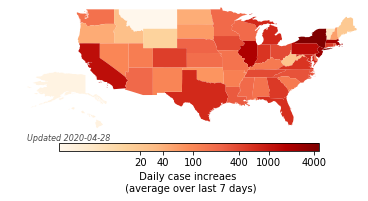

In [6]:
fig, ax = plt.subplots(1,1 ,figsize=half_w )

wp = US.plot(column='average_increase', ax=ax, cmap='OrRd'   );

wp.set_xbound(-135,-66)
wp.set_ybound(20,49.5)  

vmin =    US['average_increase'].min()
vmax =  ( US['average_increase'].max() )
 
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax)) 
 
sm._A = []
cax = fig.add_axes([0.2, 0.25, 0.6, 0.03])
cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
 

# tick_array =  [1,10,100,1000,10000,10000] 
tick_array =  [20,40,100,400,1000,4000,10000,20000,40000 ] 
log_cases = np.log( tick_array  )  
cb.set_ticks( log_cases ) 
cb.set_ticklabels( tick_array) 
cb.set_label(' Daily case increaes  \n (average over last 7 days)')

ax.axis("off")

ax.annotate('Updated '+str( df_state['Date'].iloc[-1]), 
            [-135,22 ], color=[.3,.3,.3], style='italic',fontsize=8)
 